# 提升法
## 基本思想：选择基学习器，并使每个基学习器正好弥补之前所有基学习器的缺点。

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold,StratifiedKFold,train_test_split,RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingRegressor,GradientBoostingClassifier
from sklearn.metrics import cohen_kappa_score,plot_roc_curve,mean_squared_error,confusion_matrix
from sklearn.inspection import plot_partial_dependence
from sklearn.datasets import load_boston

## 一、回归提升树
最初的AdaBoost算法由于使用指数损失函数，故仅适用于分类问题。对于回归问题，可考虑在前向分段加法模型中使用误差平方损失函数，得：
$$ \underset{\beta,G}{min}\quad L[y_i,f_{m-1}(x_i)+\beta G(x_i;\gamma)]$$
$$=[r_i^m-\beta G(x_i;\gamma)]^2$$
该方法被称为回归问题的提升法，或2-范数提升法，若使用回归树作为基学习器，则称为回归提升树。
特点：
1. 提升法会因为决策树个数M过大而可能导致过拟合。
2. 决策树的分裂次数d称为交互深度，$d=i$，则可考虑$i$个变量之间的交互效应。
3. 学习率$\eta$，也称为收缩参数，设定较小的学习率，可避免过拟合，是正则化方法的一种。

回归问题也存在其他损失函数，如拉普拉斯损失函数（绝对损失函数），胡贝尔损失函数，综合了平方损失和绝对损失的优点。
$$L[y,f(x)]=|y-f(x)|$$
$$L[y,f(x)]=
\begin{cases}
\frac{1}{2}[y-f(x)]^2 &|y-f(x)|\leq\delta \\
\delta[|y-f(x)|-\delta/2] &|y-f(x)|>\delta\\
\end{cases}
$$
算法步骤：
1. 初始化$f(x)=0$,残差即是响应变量$r_i=y_i$。
2. 对于决策树$m=1,\cdots,M$，进行M次for循环：
   >使用数据${x_i,r_i}$，估计拥有d个分裂的决策树$G_m(x)$;  
   >更新函数，$f(x)=f(x)+\eta G_m(x)$  
   >更新残差，$r_i=r_i-\eta G_m(x)$
3. 输出结果：$$f(x)=\sum_{m=1}^{M}\eta G_m(x)$$

对于回归问题，若梯度提升法的基函数为决策树，则此时梯度提升法即为回归提升树。

In [70]:
data=load_boston()
X=pd.DataFrame(data.data,columns=data.feature_names)
y=data.target

In [11]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [17]:
y.reshape(-1,1)[:5]

array([[24. ],
       [21.6],
       [34.7],
       [33.4],
       [36.2]])

In [71]:
xtrain,xtest,ytrain,ytest=train_test_split(X,y,test_size=0.3,random_state=1)

In [72]:
model=GradientBoostingRegressor(random_state=123)
model.fit(xtrain,ytrain)

GradientBoostingRegressor(random_state=123)

In [73]:
model.score(xtrain,ytrain),model.score(xtest,ytest)

(0.9818725018961298, 0.9214598819200858)

In [76]:
param_distributions={'n_estimators':range(1,301),'max_depth':range(1,11),'subsample':np.linspace(0.1,1,10),'learning_rate':np.linspace(0.1,1,10)}
kfold=KFold(n_splits=10,shuffle=True,random_state=1)
model=RandomizedSearchCV(estimator=GradientBoostingRegressor(random_state=123),param_distributions=param_distributions,n_iter=100,random_state=0)
model.fit(xtrain,ytrain)

RandomizedSearchCV(estimator=GradientBoostingRegressor(random_state=123),
                   n_iter=100,
                   param_distributions={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'max_depth': range(1, 11),
                                        'n_estimators': range(1, 301),
                                        'subsample': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=0)

In [77]:
model.best_params_

{'subsample': 0.8, 'n_estimators': 188, 'max_depth': 3, 'learning_rate': 0.1}

In [78]:
model=model.best_estimator_
model.score(xtrain,ytrain),model.score(xtest,ytest)

(0.9933867162508212, 0.9174762355671893)

Text(0.5, 1.0, 'Gradient Boosting')

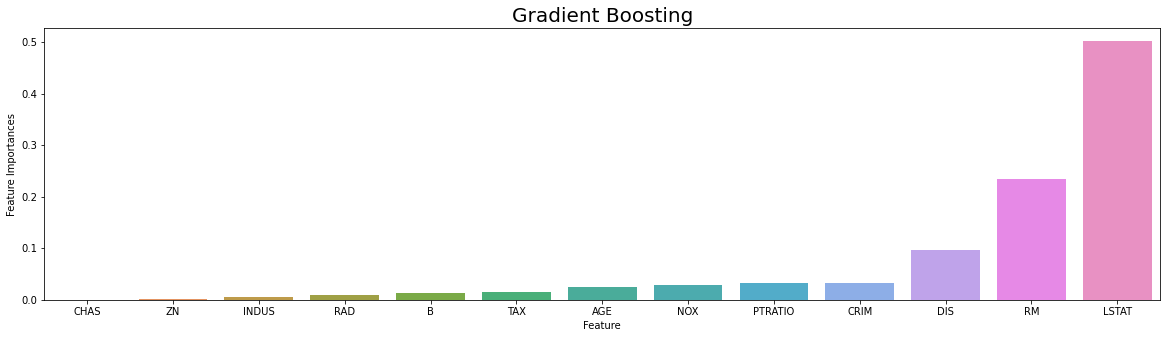

In [79]:
index=np.argsort(model.feature_importances_)
plt.figure(figsize=(20,5))
sns.barplot(x=X.columns[index],y=model.feature_importances_[index])
plt.xlabel('Feature')
plt.ylabel('Feature Importances')
plt.title('Gradient Boosting',fontsize=20)

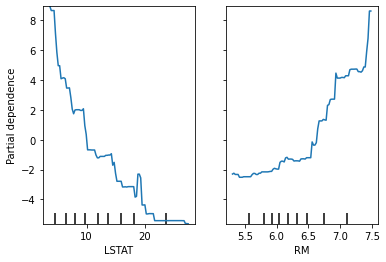

In [80]:
plot_partial_dependence(model,xtrain,['LSTAT','RM'])

In [82]:
test_mse=[]
for n_estimators in range(1,301):
    model=GradientBoostingRegressor(n_estimators=n_estimators,max_depth=3,learning_rate=0.1,subsample=0.8)
    model.fit(xtrain,ytrain)
    pred=model.predict(xtest)
    test_mse.append(mean_squared_error(ytest,pred))

72


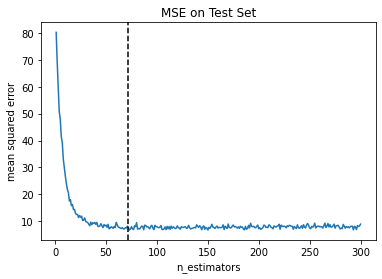

In [83]:
index=np.argmin(test_mse)
plt.plot(range(1,301),test_mse)
plt.axvline(x=index,linestyle='--',c='k')
plt.xlabel('n_estimators')
plt.ylabel('mean squared error')
plt.title('MSE on Test Set')
print(index)

## 二、二分类提升树
梯度提升法是AdaBoost的更一般情况，以非参方法估计基函数，并在函数空间使用梯度下降法近似求解。具体算法步骤为：
1. 初始化$F_0(x)=argmin \sum_i^n L(y_i,c)$，即为最优的常值函数。
2. 对于基函数$m=1,\cdots,M$，进行M次for循环：
   >计算准残差：$$r_i^m=-\left \lbrace \frac{\partial L[y_i,F(x_i)]}{\partial F(x_i)}\right \rbrace_{F(x)=F_{m-1}(x)}$$
   >将准残差对x进行回归：$$\alpha_m=\underset{\alpha,\beta}{argmin}\sum_{i=1}^{n}\left[r_i^m-\beta h(x_i;\alpha)\right]^2$$
   >计算最优步长：$$\rho_m=\underset{\rho}{argmin}\sum_{i=1}^n L[y_i,F_{m-1}(x_i)+\rho h(x_i,\alpha_m)]$$
   >更新函数：$$F_m(x)=F_{m-1}(x)+\rho_m h(x;\alpha_m)$$
3. 输出$F_M(x)$。

根据损失函数的不同可分为：

1. AdaBoost提升法，等价于使用指数损失函数的前向分段加法模型。每棵树均纠正上一棵树的错误，迫使分类器更加注重特征空间中错误分类的区域，故可降低偏差，同时由于平均化，故可降低方差。每估计完一棵树后，均更新权重：
   $$w_i=w_i*exp\lbrace{\alpha_mI[y_i\not= G_m(x_i)]}\rbrace$$
   最终结果为：$$G(x)=sign\left[\sum_{m=1}^{M}\alpha_m G_m(x)\right]$$
   AdaBoost法已不常用，因为其对错误分类的数据更加挑剔，故若数据中噪音比较大，则AdaBoost的稳健型较差。
2. 逻辑损失函数，又称二值交叉熵损失函数，对于负裕度的惩罚$-yf(x)$比指数函数更温和，且无0-1损失函数为不光滑的阶梯函数的缺点。
   损失函数为：$$L[y,f(x)]=\ln [1+exp(-yf(x))]$$


In [103]:
def get_metrics(matrix):

    accuracy=(matrix[1,1]+matrix[0,0])/matrix.sum()
    sensitivity=matrix[1,1]/matrix[1].sum()
    recall=matrix[1,1]/(matrix[:,1]).sum()

    return accuracy,sensitivity,recall

def score_metrics_hyper(model):
    
    name=str(model).split('(')[0]
    
    pred=model.predict(xtest)
    matrix=confusion_matrix(ytest,pred)
    accuracy,sensitivity,recall=get_metrics(matrix)

    print(f'{name}得分状况如下：')
    print(f'训练集准确率为：{model.score(xtrain,ytrain)}')
    print(f'测试集准确率为：{model.score(xtest,ytest)}')
    print(f'准确率为：{accuracy}\n灵敏度为：{sensitivity}\n召回率为：{recall}')
    print(f'最佳超参数集：{model.best_params_}')

    plt.figure(figsize=(5,5))
    sns.heatmap(matrix,annot=True,cmap='Blues',fmt='g')
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title('Confusion Matrix of Test Data')
    plt.tight_layout()

    model=model.best_estimator_
    index=np.argsort(model.feature_importances_)
    
    plt.figure(figsize=(20,5))
    sns.barplot(x=X.columns[index],y=model.feature_importances_[index])
    plt.xlabel('Feature')
    plt.ylabel('Feature Importances')
    plt.title(name,fontsize=20)
    plt.tight_layout()

def score_metrics(model):

    name=str(model).split('(')[0]
    
    pred=model.predict(xtest)
    matrix=confusion_matrix(ytest,pred)
    accuracy,sensitivity,recall=get_metrics(matrix)

    print(f'{name}得分状况如下：')
    print(f'训练集准确率为：{model.score(xtrain,ytrain)}')
    print(f'测试集准确率为：{model.score(xtest,ytest)}')
    print(f'准确率为：{accuracy}\n灵敏度为：{sensitivity}\n召回率为：{recall}')

    plt.figure(figsize=(5,5))
    sns.heatmap(matrix,annot=True,cmap='Blues',fmt='g')
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title('Confusion Matrix of Test Data')
    plt.tight_layout()

    index=np.argsort(model.feature_importances_)
    
    plt.figure(figsize=(20,5))
    sns.barplot(x=X.columns[index],y=model.feature_importances_[index])
    plt.xlabel('Feature')
    plt.ylabel('Feature Importances')
    plt.title(name,fontsize=20)
    plt.tight_layout()


In [86]:
data=pd.read_csv('/Users/singal/Desktop/Data/MLPython_Data/spam.csv')

In [52]:
data.head()

,A.1,A.2,A.3,A.4,A.5,A.6,A.7,A.8,A.9,A.10,...,A.49,A.50,A.51,A.52,A.53,A.54,A.55,A.56,A.57,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,spam
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,spam
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,spam
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,spam
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,spam


In [89]:
X=data.iloc[:,:-1]
y=data.iloc[:,-1]
xtrain,xtest,ytrain,ytest=train_test_split(X,y,random_state=0,test_size=0.2,stratify=y)

AdaBoostClassifier得分状况如下：
训练集准确率为：0.9456521739130435
测试集准确率为：0.9489685124864278
准确率为：0.9489685124864278
灵敏度为：0.9504132231404959
召回率为：0.9224598930481284


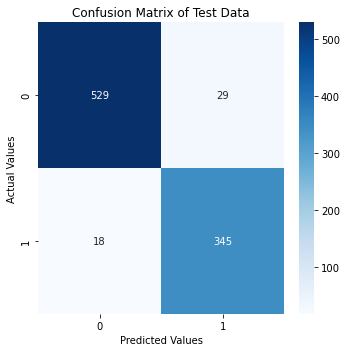

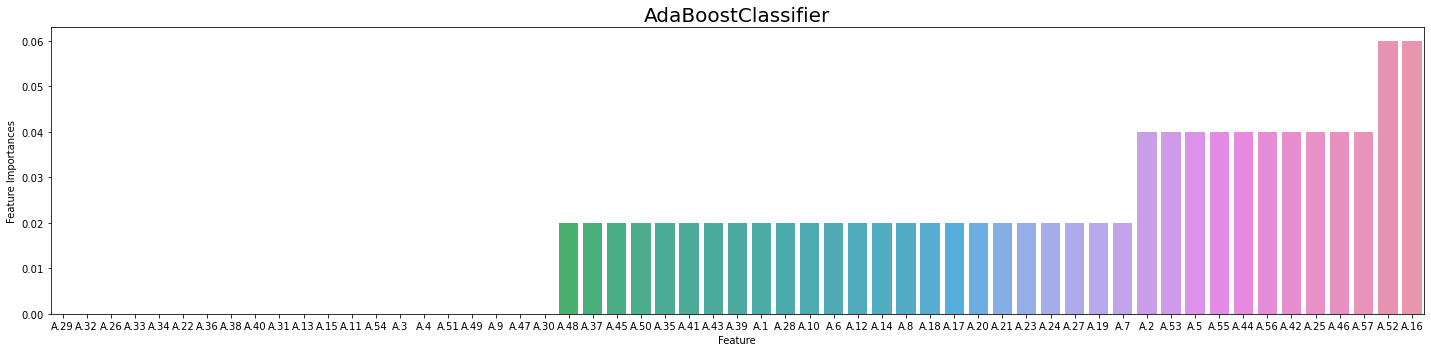

In [97]:
model=AdaBoostClassifier(random_state=123)#自适应提升法分类器默认使用SAMME.R算法
score_metrics(model.fit(xtrain,ytrain))

GradientBoostingClassifier得分状况如下：
训练集准确率为：0.9641304347826087
测试集准确率为：0.9543973941368078
准确率为：0.9543973941368078
灵敏度为：0.931129476584022
召回率为：0.952112676056338


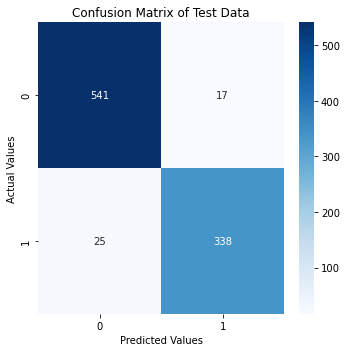

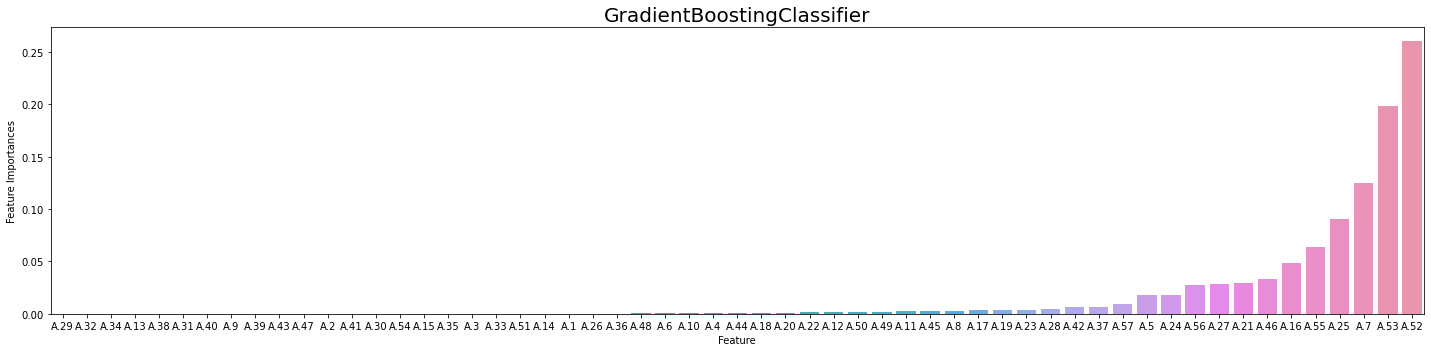

In [98]:
model=GradientBoostingClassifier(random_state=123)
score_metrics(model.fit(xtrain,ytrain))

RandomizedSearchCV得分状况如下：
训练集准确率为：0.9994565217391305
测试集准确率为：0.9500542888165038
准确率为：0.9500542888165038
灵敏度为：0.9421487603305785
召回率为：0.9318801089918256
最佳超参数集：{'subsample': 1.0, 'n_estimators': 123, 'max_depth': 7, 'learning_rate': 0.5}


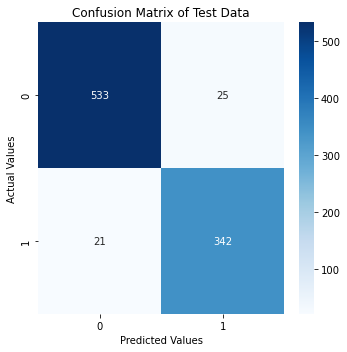

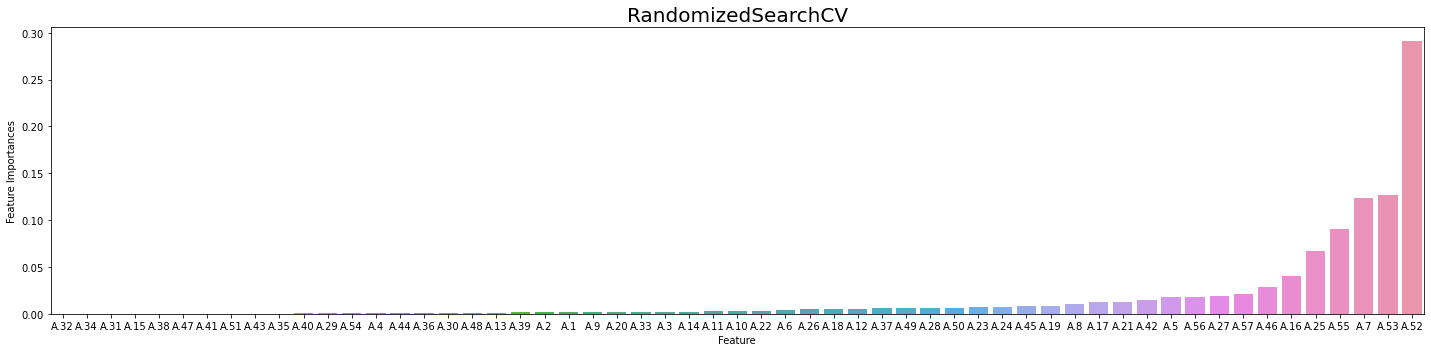

In [104]:
model=RandomizedSearchCV(GradientBoostingClassifier(random_state=123),param_distributions=param_distributions,n_iter=10,cv=kfold,random_state=66)
score_metrics_hyper(model.fit(xtrain,ytrain))

## 三、多分类提升树
多分类提升树的损失函数，又称交叉熵损失函数：$$ L[y,f(x)]=\sum_{k=1}^K I(y_i=k)\ln P(y_i=k|x_i)$$

In [105]:
data=pd.read_csv('/Users/singal/Desktop/Data/MLPython_Data/Glass.csv')
data.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [106]:
X=data.iloc[:,:-1]
y=data.iloc[:,-1]
xtrain,xtest,ytrain,ytest=train_test_split(X,y,test_size=0.3,stratify=y,random_state=0)

GradientBoostingClassifier得分状况如下：
训练集准确率为：1.0
测试集准确率为：0.8
准确率为：0.5538461538461539
灵敏度为：0.8695652173913043
召回率为：0.8333333333333334


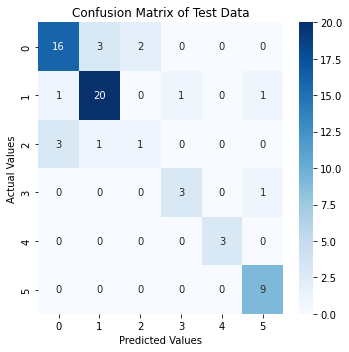

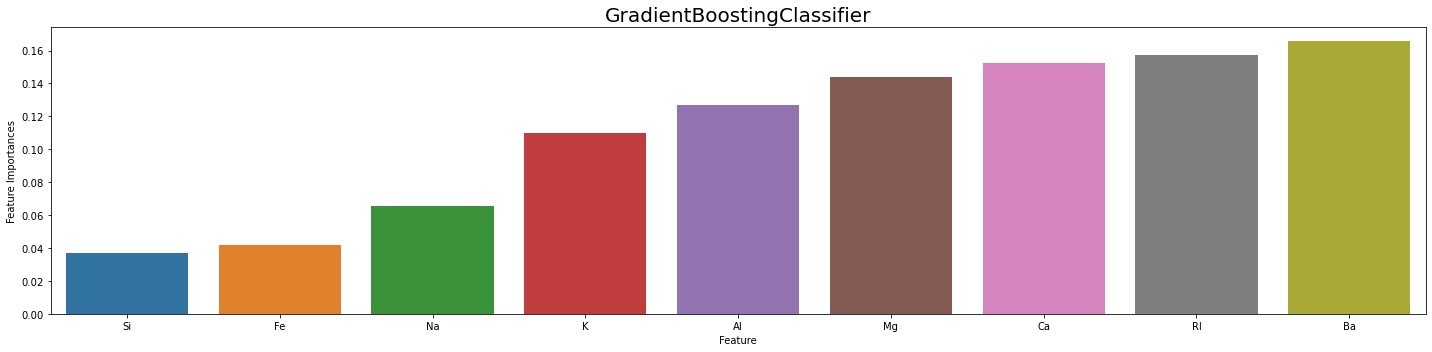

In [107]:
model=GradientBoostingClassifier(random_state=123).fit(xtrain,ytrain)
score_metrics(model)

RandomizedSearchCV得分状况如下：
训练集准确率为：0.9932885906040269
测试集准确率为：0.7384615384615385
准确率为：0.5538461538461539
灵敏度为：0.782608695652174
召回率为：0.782608695652174
最佳超参数集：{'subsample': 0.6, 'n_estimators': 17, 'max_depth': 4, 'learning_rate': 0.1}


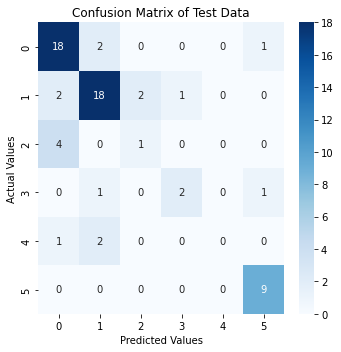

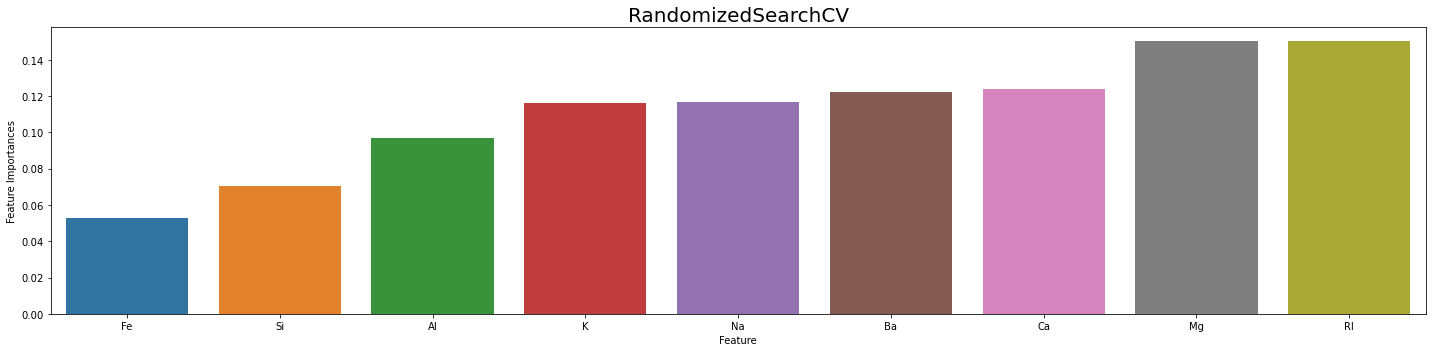

In [108]:
kfold=StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
model=RandomizedSearchCV(estimator=GradientBoostingClassifier(random_state=123),param_distributions=param_distributions,cv=kfold,random_state=66)
score_metrics_hyper(model.fit(xtrain,ytrain))

## 四、XGBoost算法
若样本容量较大，则推荐使用陈天奇团队开发的xgboost模块。该模块仍然使用梯度提升法，但作了许多改进：使用牛顿下降法计算下降方向、改进决策树算法、使用稀疏矩阵等。既适用于分类问题，也适用于回归问题。
### 1、回归问题

In [111]:
import xgboost as xgb

In [139]:
data=load_boston()
X=pd.DataFrame(data.data,columns=data.feature_names)
y=data.target.reshape(-1,1)
xtrain,xtest,ytrain,ytest=train_test_split(X,y,test_size=0.3,random_state=1)

In [140]:
model=xgb.XGBRegressor(objective='reg:squarederror',n_estimators=300,max_depth=6,subsample=0.6,colsample_bytree=0.8,learning_rate=0.1,random_state=0)
model.fit(xtrain,ytrain)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [141]:
model.score(xtrain,ytrain),model.score(xtest,ytest)

(0.9999910804157431, 0.9027337476066284)

In [148]:
pred=model.predict(xtest)
rmse=np.sqrt(mean_squared_error(ytest,pred))
rmse

2.9857810494791392

In [149]:
params={'objective':'reg:squarederror','max_depth':6,'subsample':0.6,'colsample_bytree':0.8,'learning_rate':0.1}
dtrain=xgb.DMatrix(data=xtrain,label=ytrain)#DataMatrix，优化了数据结构

In [151]:
results=xgb.cv(dtrain=dtrain,params=params,nfold=10,metrics='rmse',num_boost_round=300,as_pandas=True,seed=123)#num_round_boost表示基学习器的个数

In [156]:
results.head(),results.shape

(   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
 0        21.449186        0.185967       21.430464       1.797494
 1        19.474505        0.186958       19.472604       1.707953
 2        17.704069        0.173372       17.740954       1.636270
 3        16.110092        0.167608       16.209880       1.567481
 4        14.679248        0.153306       14.785130       1.480004,
 (300, 4))

### 2、分类问题

In [157]:
data=pd.read_csv('/Users/singal/Desktop/Data/MLPython_Data/spam.csv')
X=data.iloc[:,:-1]
y=data.iloc[:,-1]
xtrain,xtest,ytrain,ytest=train_test_split(X,y,random_state=0,test_size=0.2,stratify=y)

In [158]:
model=xgb.XGBClassifier(objective='binary:logistic',n_estimators=300,max_depth=6,subsample=0.6,colsample_bytree=0.8,learning_rate=0.1,random_state=0)
model.fit(xtrain,ytrain)

/Users/singal/miniforge3/envs/py38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:37:23] WARNING: /Users/ktietz/demo/mc3/conda-bld/xgboost-split_1628682908089/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [159]:
model.score(xtest,ytest)

0.9565689467969598

In [162]:
pred=model.predict(xtest)
matrix=confusion_matrix(ytest,pred)
accuracy,sensitivity,recall=get_metrics(matrix)
print(f'准确率为：{accuracy}\n灵敏度为：{sensitivity}\n召回率为：{recall}')

准确率为：0.9565689467969598
灵敏度为：0.9449035812672176
召回率为：0.9449035812672176
